<a href="https://colab.research.google.com/github/PurushottamMNagarkar/Gold-Price-Prediction-using-Machine-Learning/blob/main/Gold_Price_Prediction_using_Machine_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")
sns.set_style("darkgrid", {"grid.color": ".6",
                           "grid.linestyle": ":"})

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import Lasso

from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

In [2]:
dataset = pd.read_csv("gold_price_data.csv" , parse_dates=["Date"])

In [3]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2290 entries, 0 to 2289
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   Date     2290 non-null   datetime64[ns]
 1   SPX      2290 non-null   float64       
 2   GLD      2290 non-null   float64       
 3   USO      2290 non-null   float64       
 4   SLV      2290 non-null   float64       
 5   EUR/USD  2290 non-null   float64       
dtypes: datetime64[ns](1), float64(5)
memory usage: 107.5 KB


In [4]:
dataset.isna().sum().sort_values(ascending=False)

,0
Date,0
SPX,0
GLD,0
USO,0
SLV,0
EUR/USD,0


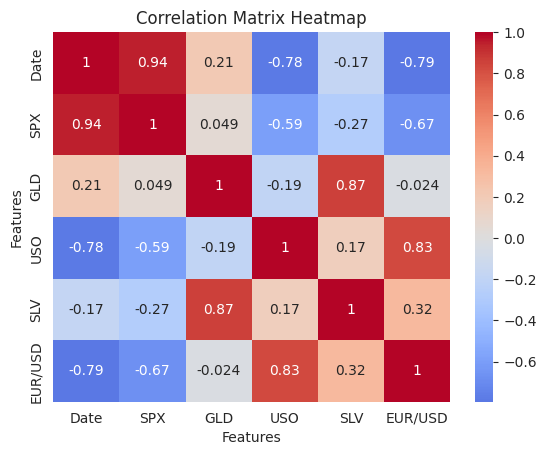

In [5]:
correlation = dataset.corr()

sns.heatmap(correlation , cmap = 'coolwarm' , center=0 , annot=True )

plt.title('Correlation Matrix Heatmap')
plt.xlabel('Features')
plt.ylabel('Features')
plt.show()

In [6]:
dataset.drop('SLV', axis=1, inplace=True)

In [7]:
dataset.drop('Date', axis=1, inplace=True)

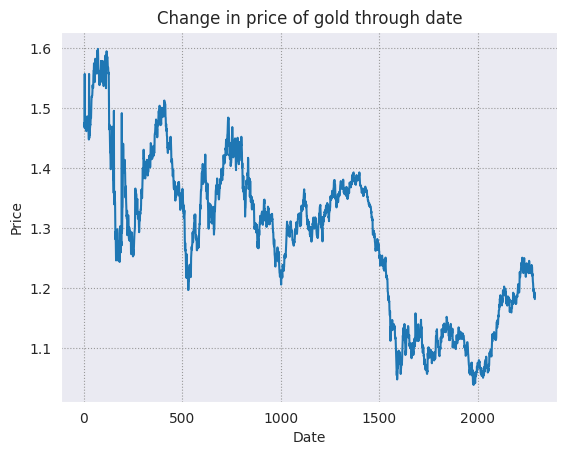

In [8]:
dataset['EUR/USD'].plot()
plt.title('Change in price of gold through date')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

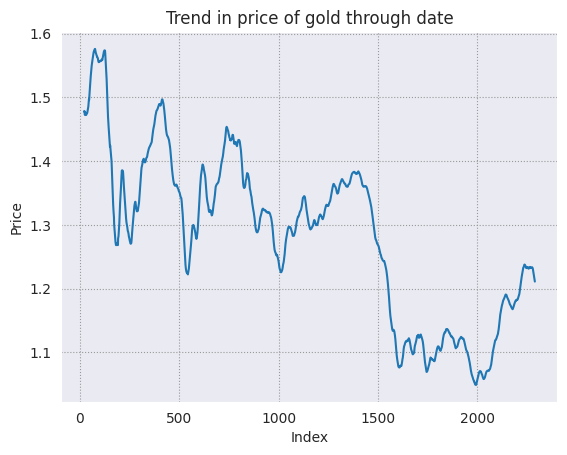

In [13]:
# apply rolling mean with window size of 3
dataset["price_trend"] = dataset["EUR/USD"]\
    .rolling(window=20).mean()

# reset the index to date column
dataset.reset_index(drop=True, inplace=True)

# since we have used rolling method
# for 20 rows first 2 rows will be NAN
dataset["price_trend"].loc[20:].plot()

# set title of the chart
plt.title("Trend in price of gold through date")

# set x_label of the plot
plt.xlabel("Index")
plt.ylabel("Price")
plt.show()

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

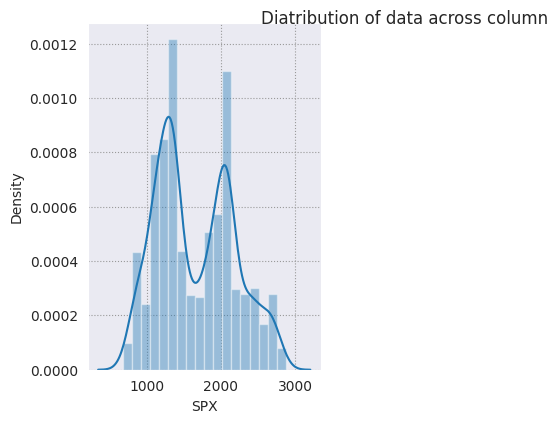

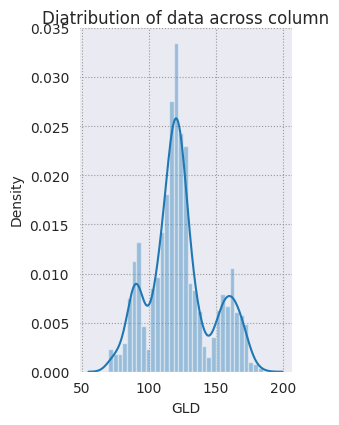

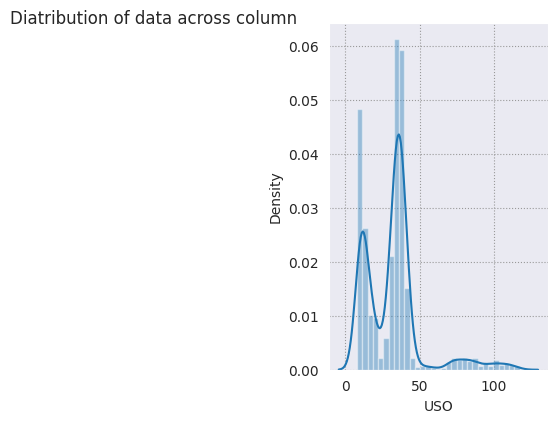

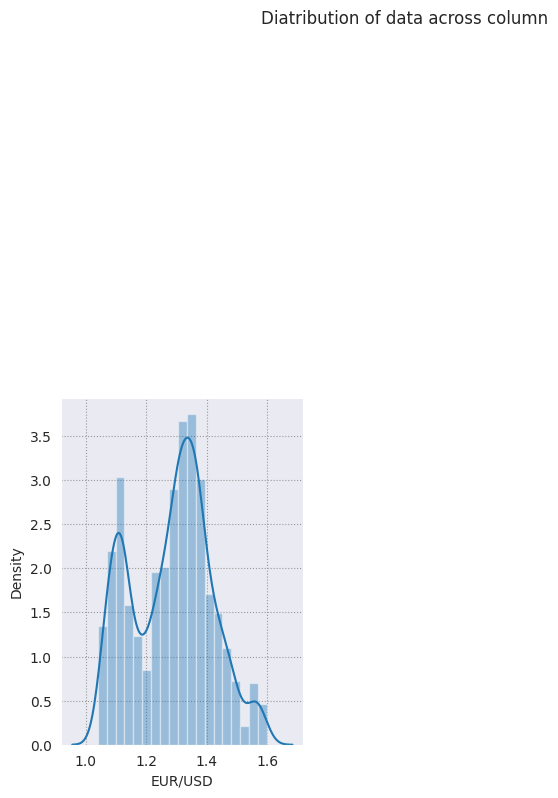

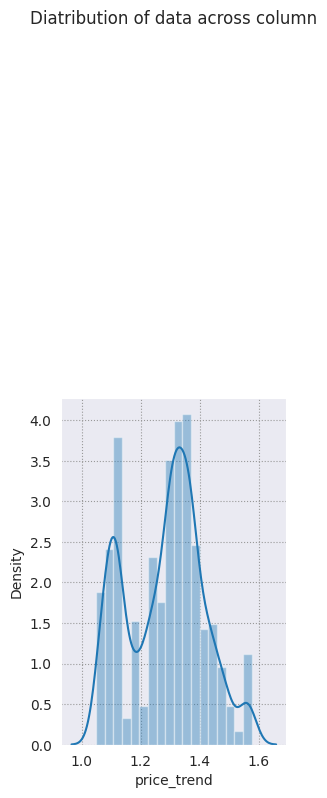

In [19]:
fig = plt.figure(figsize=(8, 8))

fig.suptitle('Diatribution of data across column')
temp = dataset.columns.tolist()
for i,item in enumerate(temp):
  fig = plt.figure(figsize=(8, 8))

fig.suptitle('Diatribution of data across column')
temp = dataset.columns.tolist()
for i,item in enumerate(temp):
    fig = plt.figure(figsize=(8, 8)) #indented this line
    fig.suptitle('Diatribution of data across column') #indented this line

    plt.subplot(2,3,i+1) #indented this line
    sns.distplot(dataset[item], kde=True) #indented this line
    plt.tight_layout(pad=0.4 , w_pad=0.4 , h_pad=2.0) #removed duplicate w_pad #indented this line
plt.show()


In [21]:
print(dataset.skew(axis=0 , skipna=True)) # Removing the .drop("Date", axis=1) part


SPX            0.300362
GLD            0.334138
USO            1.699331
EUR/USD       -0.005292
price_trend   -0.029588
dtype: float64


In [24]:
# Check if 'USD' column exists in the DataFrame
if 'USD' in dataset.columns:
    # Apply the square root transformation if the column exists
    dataset["USD"] = dataset["USD"].apply(lambda x: np.sqrt(x))
else:
    # Print an error message or handle the case where the column is missing
    print("Error: 'USD' column not found in the DataFrame.")
    # Optionally, you can try to identify the correct column name or reload the data
    print("Available columns:", dataset.columns)

Error: 'USD' column not found in the DataFrame.
Available columns: Index(['SPX', 'GLD', 'USO', 'EUR/USD', 'price_trend'], dtype='object')


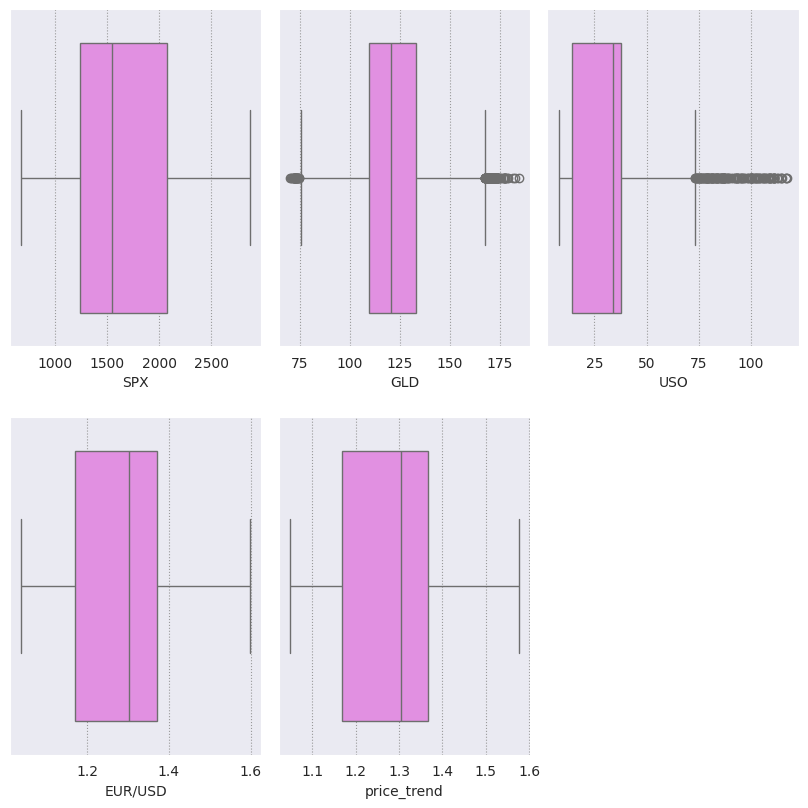

In [26]:
fig = plt.figure(figsize=(8, 8))
# Check if 'Date' column still exists before dropping it
if 'Date' in dataset.columns:
    temp = dataset.drop("Date", axis=1).columns.tolist()
else:
    temp = dataset.columns.tolist()
for i, item in enumerate(temp):
    plt.subplot(2, 3, i+1)
    sns.boxplot(data=dataset, x=item, color='violet')
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=2.0)
plt.show()

In [27]:
def outlier_removal(column):
    # Capping the outlier rows with Percentiles
    upper_limit = column.quantile(.95)
    # set upper limit to 95percentile
    lower_limit = column.quantile(.05)
    # set lower limit to 5 percentile
    column.loc[(column > upper_limit)] = upper_limit
    column.loc[(column < lower_limit)] = lower_limit
    return column

In [28]:
# Normalize outliers in columns except Date

dataset[['SPX', 'GLD', 'USO', 'EUR/USD']] = \
    dataset[['SPX', 'GLD', 'USO', 'EUR/USD']].apply(outlier_removal)


In [30]:
# select the features and target variable
# Check if 'Date' column still exists before dropping it
if 'Date' in dataset.columns:
    X = dataset.drop(['Date', 'EUR/USD'], axis=1)
else:
    X = dataset.drop(['EUR/USD'], axis=1)

y = dataset['EUR/USD']
# dividing dataset in to train test
x_train, x_test,\
    y_train, y_test = train_test_split(X, y,
                                       test_size=0.2)

In [31]:
# Create an instance of the StandardScaler
scaler = StandardScaler()

# Fit the StandardScaler on the training dataset
scaler.fit(x_train)

# Transform the training dataset
# using the StandardScaler
x_train_scaled = scaler.transform(x_train)
x_test_scaled = scaler.transform(x_test)

In [32]:
# Impute missing values using SimpleImputer
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='mean') # Replace NaNs with the mean of each column

# Fit and transform the imputer on the scaled training data
x_train_scaled = imputer.fit_transform(x_train_scaled)

# Transform the scaled test data using the trained imputer
x_test_scaled = imputer.transform(x_test_scaled)

# Create a PolynomialFeatures object of degree 2
poly = PolynomialFeatures(degree=2)

# Create a Lasso object
lasso = Lasso()

# Define a dictionary of parameter
#values to search over
param_grid = {'lasso__alpha': [1e-4, 1e-3, 1e-2,
                            1e-1, 1, 5, 10,
                            20, 30, 40]}

# Create a pipeline that first applies
# polynomial features and then applies Lasso regression
pipeline = make_pipeline(poly, lasso)

# Create a GridSearchCV object with
#the pipeline and parameter grid
lasso_grid_search = GridSearchCV(pipeline,
                                param_grid,
                                scoring='r2', cv=3)

# Fit the GridSearchCV object to the training data
lasso_grid_search.fit(x_train_scaled, y_train)

# Predict the target variable using
# the fitted model and the test data
y_pred = lasso_grid_search.predict(x_train_scaled)

# Compute the R-squared of the fitted model on the train data
r2 = r2_score(y_train, y_pred)

# Print the R-squared
print("R-squared: ", r2)

# Print the best parameter values and score
print('Best parameter values: ',
    lasso_grid_search.best_params_)
print('Best score: ',
    lasso_grid_search.best_score_)

R-squared:  0.9677059193357181
Best parameter values:  {'lasso__alpha': 0.0001}
Best score:  0.9665314164731978


In [33]:

# Insiate param grid for which to search
param_grid = {'n_estimators': [50, 80, 100],
              'max_depth': [3, 5, 7]}

# create instance of the Randomforest regressor
rf = RandomForestRegressor()

# Define Girdsearch with random forest
# object parameter grid scoring and cv
rf_grid_search = GridSearchCV(rf, param_grid, scoring='r2', cv=2)

# Fit the GridSearchCV object to the training data

rf_grid_search.fit(x_train_scaled, y_train)

# Print the best parameter values and score
print('Best parameter values: ', rf_grid_search.best_params_)
print('Best score: ', rf_grid_search.best_score_)

Best parameter values:  {'max_depth': 7, 'n_estimators': 50}
Best score:  0.9761722256739093


In [34]:

# Compute the R-squared of the
# fitted model on the test data
r2 = r2_score(y_test,
              rf_grid_search.predict(x_test_scaled))

# Print the R-squared
print("R-squared:", r2)

R-squared: 0.9762874439506698


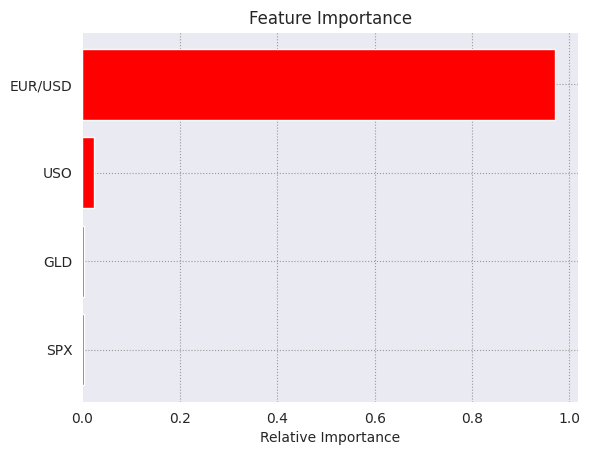

In [36]:
features = dataset.columns

# store the importance of the feature
importances = rf_grid_search.best_estimator_.\
    feature_importances_


indices = np.argsort(importances)

# title of the graph
plt.title('Feature Importance')

plt.barh(range(len(indices)),
         importances[indices],
         color='red',
         align='center')

# plot bar chart
plt.yticks(range(len(indices)),
           [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In [37]:

# Create an instance of the XGBRegressor model
model_xgb = XGBRegressor()

# Fit the model to the training data
model_xgb.fit(x_train_scaled, y_train)

# Print the R-squared score on the training data
print("Xgboost Accuracy =", r2_score(
    y_train, model_xgb.predict(x_train_scaled)))

Xgboost Accuracy = 0.9994731487458128


In [38]:

# Print the R-squared score on the test data
print("Xgboost Accuracy on test data =",
      r2_score(y_test,
               model_xgb.predict(x_test_scaled)))

Xgboost Accuracy on test data = 0.9856022143142268


In [40]:
!pip install eli5

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.2/216.2 kB 4.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for eli5: filename=eli5-0.13.0-py2.py3-none-any.whl size=107721 sha256=3b20343d0dca9f1b39ad45d86e12cc251952fd0fd411983a4d4ba6c957af921a
  Stored in directory: /root/.cache/pip/wheels/ec/68/a9/de7d374ecb6f53462ce0eec8326fbab91b6228c82e67428d0d
Successfully built eli5


In [1]:
!pip install eli5==0.13.0 scikit-learn==1.2.2

In [7]:
# Impute missing values using SimpleImputer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import pandas as pd  # Import pandas

# Load the dataset
dataset = pd.read_csv("gold_price_data.csv" , parse_dates=["Date"])  # Load the dataset here

# Assuming 'X' and 'y' are already defined (your features and target variable):
X = dataset.drop(['EUR/USD', 'Date'], axis=1)  # Drop the 'Date' column here
y = dataset['EUR/USD']

# Split the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2) # Assuming 'X' and 'y' are defined

# Create an instance of the StandardScaler
scaler = StandardScaler()

# Fit the StandardScaler on the training dataset
scaler.fit(x_train)

# Transform the training and testing datasets using the StandardScaler
x_train_scaled = scaler.transform(x_train)
x_test_scaled = scaler.transform(x_test)

# Create an instance of the SimpleImputer
imputer = SimpleImputer(strategy='mean')  # Replace NaNs with the mean of each column

# Fit and transform the imputer on the scaled training data
x_train_scaled = imputer.fit_transform(x_train_scaled)

# Transform the scaled test data using the trained imputer
x_test_scaled = imputer.transform(x_test_scaled)

In [9]:
from xgboost import XGBRegressor
from sklearn.metrics import r2_score

# Create an instance of the XGBRegressor model
model_xgb = XGBRegressor()

# Fit the model to the training data
model_xgb.fit(x_train_scaled, y_train)

# Print the R-squared score on the training data
print("Xgboost Accuracy =", r2_score(y_train, model_xgb.predict(x_train_scaled)))

Xgboost Accuracy = 0.9988814114944533


In [10]:

import eli5 as eli
# weight of variables in xgboost model
# Get the names of the features
feature_names = x_train.columns.tolist()

# Explain the weights of the features using ELI5
eli.explain_weights(model_xgb,
                    feature_names=feature_names)

Weight,Feature
0.8601,USO
0.0531,SLV
0.0448,SPX
0.0421,GLD
